In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial

from timeit import default_timer
# from utilities3 import *

torch.manual_seed(0)
np.random.seed(0)

import scipy.io
import h5py
import operator
from functools import reduce
from functools import partial
import datetime

In [ ]:
import torch
import numpy as np
import scipy.io
import h5py
import torch.nn as nn

import operator
from functools import reduce
from functools import partial
import datetime
#################################################
#
# Utilities
#
#################################################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# reading data
class MatReader(object):
    def __init__(self, file_path, to_torch=True, to_cuda=False, to_float=True):
        super(MatReader, self).__init__()

        self.to_torch = to_torch
        self.to_cuda = to_cuda
        self.to_float = to_float

        self.file_path = file_path

        self.data = None
        self.old_mat = None
        self._load_file()

    def _load_file(self):
        try:
            self.data = scipy.io.loadmat(self.file_path)
            self.old_mat = True
        except:
            self.data = h5py.File(self.file_path)
            self.old_mat = False

    def load_file(self, file_path):
        self.file_path = file_path
        self._load_file()

    def read_field(self, field):
        x = self.data[field]

        if not self.old_mat:
            x = x[()]
            x = np.transpose(x, axes=range(len(x.shape) - 1, -1, -1))

        if self.to_float:
            x = x.astype(np.float32)

        if self.to_torch:
            x = torch.from_numpy(x)

            if self.to_cuda:
                x = x.cuda()

        return x

    def set_cuda(self, to_cuda):
        self.to_cuda = to_cuda

    def set_torch(self, to_torch):
        self.to_torch = to_torch

    def set_float(self, to_float):
        self.to_float = to_float

# normalization, pointwise gaussian
class UnitGaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(UnitGaussianNormalizer, self).__init__()

        # x could be in shape of ntrain*n or ntrain*T*n or ntrain*n*T
        self.mean = torch.mean(x, 0)
        self.std = torch.std(x, 0)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        if sample_idx is None:
            std = self.std + self.eps # n
            mean = self.mean
        else:
            if len(self.mean.shape) == len(sample_idx[0].shape):
                std = self.std[sample_idx] + self.eps  # batch*n
                mean = self.mean[sample_idx]
            if len(self.mean.shape) > len(sample_idx[0].shape):
                std = self.std[:,sample_idx]+ self.eps # T*batch*n
                mean = self.mean[:,sample_idx]

        # x is in shape of batch*n or T*batch*n
        x = (x * std) + mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()

# normalization, Gaussian
class GaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(GaussianNormalizer, self).__init__()

        self.mean = torch.mean(x)
        self.std = torch.std(x)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        x = (x * (self.std + self.eps)) + self.mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()


# normalization, scaling by range
class RangeNormalizer(object):
    def __init__(self, x, low=0.0, high=1.0):
        super(RangeNormalizer, self).__init__()
        mymin = torch.min(x, 0)[0].view(-1)
        mymax = torch.max(x, 0)[0].view(-1)

        self.a = (high - low)/(mymax - mymin)
        self.b = -self.a*mymax + high

    def encode(self, x):
        s = x.size()
        x = x.view(s[0], -1)
        x = self.a*x + self.b
        x = x.view(s)
        return x

    def decode(self, x):
        s = x.size()
        x = x.view(s[0], -1)
        x = (x - self.b)/self.a
        x = x.view(s)
        return x

#loss function with rel/abs Lp loss
class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        #Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)

# Sobolev norm (HS norm)
# where we also compare the numerical derivatives between the output and target
class HsLoss(object):
    def __init__(self, d=2, p=2, k=1, a=None, group=False, size_average=True, reduction=True):
        super(HsLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.k = k
        self.balanced = group
        self.reduction = reduction
        self.size_average = size_average

        if a == None:
            a = [1,] * k
        self.a = a

    def rel(self, x, y):
        num_examples = x.size()[0]
        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)
        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)
        return diff_norms/y_norms

    def __call__(self, x, y, a=None):
        nx = x.size()[1]
        ny = x.size()[2]
        k = self.k
        balanced = self.balanced
        a = self.a
        x = x.view(x.shape[0], nx, ny, -1)
        y = y.view(y.shape[0], nx, ny, -1)

        k_x = torch.cat((torch.arange(start=0, end=nx//2, step=1),torch.arange(start=-nx//2, end=0, step=1)), 0).reshape(nx,1).repeat(1,ny)
        k_y = torch.cat((torch.arange(start=0, end=ny//2, step=1),torch.arange(start=-ny//2, end=0, step=1)), 0).reshape(1,ny).repeat(nx,1)
        k_x = torch.abs(k_x).reshape(1,nx,ny,1).to(x.device)
        k_y = torch.abs(k_y).reshape(1,nx,ny,1).to(x.device)

        x = torch.fft.fftn(x, dim=[1, 2])
        y = torch.fft.fftn(y, dim=[1, 2])

        if balanced==False:
            weight = 1
            if k >= 1:
                weight += a[0]**2 * (k_x**2 + k_y**2)
            if k >= 2:
                weight += a[1]**2 * (k_x**4 + 2*k_x**2*k_y**2 + k_y**4)
            weight = torch.sqrt(weight)
            loss = self.rel(x*weight, y*weight)
        else:
            loss = self.rel(x, y)
            if k >= 1:
                weight = a[0] * torch.sqrt(k_x**2 + k_y**2)
                loss += self.rel(x*weight, y*weight)
            if k >= 2:
                weight = a[1] * torch.sqrt(k_x**4 + 2*k_x**2*k_y**2 + k_y**4)
                loss += self.rel(x*weight, y*weight)
            loss = loss / (k+1)

        return loss

# A simple feedforward neural network
class DenseNet(torch.nn.Module):
    def __init__(self, layers, nonlinearity, out_nonlinearity=None, normalize=False):
        super(DenseNet, self).__init__()

        self.n_layers = len(layers) - 1

        assert self.n_layers >= 1

        self.layers = nn.ModuleList()

        for j in range(self.n_layers):
            self.layers.append(nn.Linear(layers[j], layers[j+1]))

            if j != self.n_layers - 1:
                if normalize:
                    self.layers.append(nn.BatchNorm1d(layers[j+1]))

                self.layers.append(nonlinearity())

        if out_nonlinearity is not None:
            self.layers.append(out_nonlinearity())

    def forward(self, x):
        for _, l in enumerate(self.layers):
            x = l(x)

        return x


# print the number of parameters
def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul, 
                    list(p.size()+(2,) if p.is_complex() else p.size()))
    return c

### Data Loading

In [ ]:
# reading data
class MatReader(object):
    def __init__(self, file_path, to_torch=True, to_cuda=False, to_float=True):
        super(MatReader, self).__init__()

        self.to_torch = to_torch
        self.to_cuda = to_cuda
        self.to_float = to_float

        self.file_path = file_path

        self.data = None
        self.old_mat = None
        self._load_file()

    def _load_file(self):
        try:
            self.data = scipy.io.loadmat(self.file_path)
            self.old_mat = True
        except:
            self.data = h5py.File(self.file_path)
            self.old_mat = False

    def load_file(self, file_path):
        self.file_path = file_path
        self._load_file()

    def read_field(self, field):
        x = self.data[field]

        if not self.old_mat:
            x = x[()]
            x = np.transpose(x, axes=range(len(x.shape) - 1, -1, -1))

        if self.to_float:
            x = x.astype(np.float32)

        if self.to_torch:
            x = torch.from_numpy(x)

            if self.to_cuda:
                x = x.cuda()

        return x

    def set_cuda(self, to_cuda):
        self.to_cuda = to_cuda

    def set_torch(self, to_torch):
        self.to_torch = to_torch

    def set_float(self, to_float):
        self.to_float = to_float

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
################################################################
# Data Path
################################################################
sys_data_PATH = '/content/drive/My Drive/Colab Notebooks/data/sys_data.mat'
obs_data_PATH = '/content/drive/My Drive/Colab Notebooks/data/obs_data.mat'

In [ ]:
sys_reader = MatReader(sys_data_PATH)
sys_data = sys_reader.read_field('sys_data')

obs_reader = MatReader(obs_data_PATH)
obs_data = obs_reader.read_field('obs_data')

In [ ]:
subsampling = 2
sys_data = sys_data[:,::subsampling,:]
obs_data = obs_data[:,::subsampling,:]

In [ ]:
nt = sys_data.shape[1]
nx = sys_data.shape[2]

print(nt)
print(nx)

50
48


In [ ]:
obs_data.shape

torch.Size([1200, 50, 48])

In [ ]:
initial = obs_data[:, :-1, :]
zeros_pad = torch.zeros((initial.shape[0], 1, initial.shape[2]))
initial_padzero = torch.cat([initial, zeros_pad], dim=1)
print('initial_padzero shape', initial_padzero.shape)

boundary = sys_data[:, 1:, -1:]
#print('initial boundary shape', boundary.shape)
boundary = boundary.repeat(1,1,nx)
boundary_padzero = torch.cat([boundary, zeros_pad], dim=1)
print('boundary shape', boundary_padzero.shape)

input = torch.cat([initial_padzero, boundary_padzero], dim=-1)
output = obs_data[:,1:,:]
output = torch.cat([output, zeros_pad], dim=1)
print(input.shape, output.shape)

initial_padzero shape torch.Size([1200, 50, 48])
boundary shape torch.Size([1200, 50, 48])
torch.Size([1200, 50, 96]) torch.Size([1200, 50, 48])


Text(0.5, 0.92, 'Observer')

<Figure size 432x288 with 0 Axes>

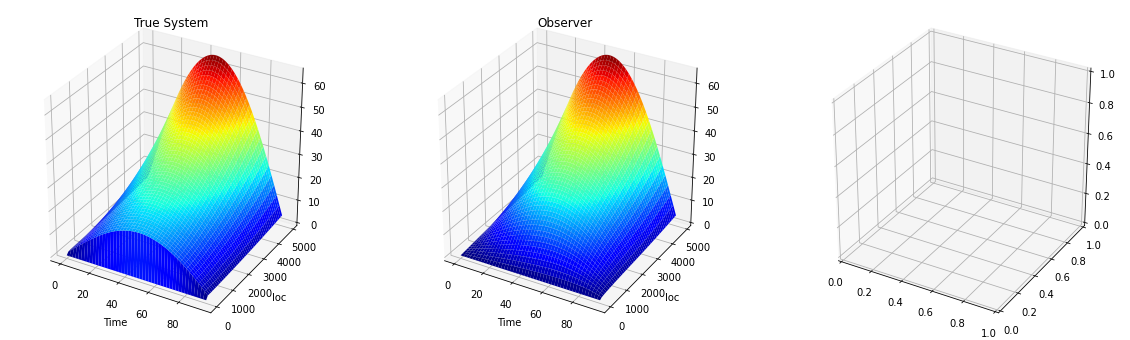

In [ ]:
index = 5

f = plt.figure()
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 6), subplot_kw={"projection": "3d"})
# Make data.
Y = np.arange(0, 5000, 100)
X = np.arange(0, 96, 2)
X, Y = np.meshgrid(X, Y)
vmax = np.max(sys_data[index, :, :].detach().numpy())

# Plot the surface.
surf1 = ax[0].plot_surface(X, Y, sys_data[index, :, :].detach().numpy(), cmap='jet', vmin=0, vmax=vmax)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('loc')
ax[0].set_zlim([0, vmax])
ax[0].set_title('True System')
surf2 = ax[1].plot_surface(X, Y, obs_data[index, :, :].detach().numpy(), cmap='jet', vmin=0, vmax=vmax)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('loc')
ax[1].set_zlim([0, vmax])
ax[1].set_title('Observer')


### LSTM

In [ ]:
class LSTM(nn.Module):
    def __init__(self, layer, width, x_size=512):
        super(LSTM, self).__init__()

        self.num_layers = layer
        self.hidden_size = width
        self.x_size = x_size

        self.lstm = nn.LSTM(input_size=x_size, hidden_size=width, num_layers=layer)

        self.fc = nn.Linear(width, x_size//2)

    def forward(self, x, h=None, c=None):

        T_size = x.shape[0]
        batch_size = x.shape[1]

        # h, c (num_layers * num_directions, batch, hidden_size)
        if h ==None:
            h, c = self.init_hidden(shape=(self.num_layers, batch_size, self.hidden_size), device=x.device)

        #input (seq_len, batch, input_size)
        out, (h, c) = self.lstm(x.view(T_size, batch_size, self.x_size), (h, c))

        out = self.fc(out)

        return out, h, c

    def init_hidden(self, shape, device):
        return (torch.zeros(shape, device=device),
                torch.zeros(shape, device=device))

    def count_params(self):
        c = 0
        for p in self.parameters():
            c += reduce(operator.mul, list(p.size()))

        return c

In [ ]:
Ntrain = 1000 # training instances
Ntest = 200 # testing instances

nt = input.shape[1]
nx = output.shape[2]


t = 10
T_iter = nt//t

ntrain = Ntrain * T_iter * t
ntest = Ntest * T_iter * t

s =  nx

batch_size = 20
learning_rate = 0.001

epochs = 100
step_size = 10
gamma = 0.5
ep_print = 1

layer = 1
width = 1000

print('layer, width, batch_size, learning_rate, epochs', layer, width, batch_size, learning_rate, epochs)

layer, width, batch_size, learning_rate, epochs 1 1000 20 0.001 100


### Train Model

In [ ]:
x_train = input[:Ntrain, :, :].reshape((Ntrain, T_iter, t, nx*2))
y_train = output[:Ntrain, :, :].reshape((Ntrain, T_iter, t, nx))
print(x_train.shape)
print(y_train.shape)
x_test = input[-Ntest:, :, :].reshape((Ntest, T_iter, t, nx*2))
y_test = output[-Ntest:, :, :].reshape((Ntest, T_iter, t, nx))

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

torch.Size([1000, 5, 10, 96])
torch.Size([1000, 5, 10, 48])


In [ ]:
model = LSTM(layer=layer, width=width, x_size=nx*2).cuda()

print(model.count_params())

4440048


In [ ]:
########### training
myloss = LpLoss(size_average=False)
# y_normalizer.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

error = np.zeros((epochs+1, 2))
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    train_overall = 0
    train_traj = np.zeros(T_iter, )

    for xx, yy in train_loader:
        xx = xx.to(device)
        yy = yy.to(device)
        h = None
        c = None
        y_pred = torch.zeros_like(yy).to(device)

        for i in range(0, T_iter):

            # xx,yy: (batch, T_iter, t, s)
            if(i == T_iter-1):
              x = xx[:, i, :-1, :].permute(1,0,2) # (t, batch, s)
              y = yy[:, i, :-1, :].permute(1,0,2) # (t, batch, s)
            else:
              x = xx[:, i, :, :].permute(1,0,2) # (t, batch, s)
              y = yy[:, i, :, :].permute(1,0,2) # (t, batch, s)

            im, h, c = model(x, h, c)

            h = h.detach()
            c = c.detach()

            if(i == T_iter-1):
              y_pred[:, i, :-1, :] = im.permute(1,0,2)
            else:
              y_pred[:, i, :, :] = im.permute(1,0,2)

            optimizer.zero_grad()
            
            loss = myloss(im.reshape(-1, s), y.reshape(-1, s))
            loss.backward()
            optimizer.step()

            train_traj[i] += loss.item()
            train_l2 += loss.item()
                    
        #mse = F.mse_loss(y_pred.reshape(batch_size, -1), yy.reshape(batch_size, -1), reduction='mean')
        #train_mse += mse.item()
        loss_overall = myloss(y_pred.reshape(batch_size, -1, s), yy.reshape(batch_size, -1, s))
        train_overall += loss_overall.item()
        

    if ep % ep_print == ep_print-1:
        test_l2 = 0
        test_traj = np.zeros(T_iter, )
        test_overall = 0
        model.eval()
        with torch.no_grad():
            for xx, yy in test_loader:
                xx = xx.to(device)
                yy = yy.to(device)
                h = None
                c = None
                for i in range(0, T_iter):
                    # xx,yy: (batch, T_iter, t, s)
                    if(i == T_iter-1):
                      x = xx[:, i, :-1, :].permute(1,0,2) # (t, batch, s)
                      y = yy[:, i, :-1, :].permute(1,0,2) # (t, batch, s)
                    else:
                      x = xx[:, i, :, :].permute(1,0,2) # (t, batch, s)
                      y = yy[:, i, :, :].permute(1,0,2) # (t, batch, s)

                    im, h, c = model(x, h, c)
                    if(i == T_iter-1):
                      y_pred[:, i, :-1, :] = im.permute(1,0,2)
                    else:
                      y_pred[:, i, :, :] = im.permute(1,0,2)

                    loss = myloss(im.reshape(-1, s), y.reshape(-1, s))
                    test_traj[i] += loss.item()
                    test_l2 += loss.item()
                loss_overall = myloss(y_pred.reshape(batch_size, -1, s), yy.reshape(batch_size, -1, s))
                test_overall += loss_overall.item()
        

        t2 = default_timer()
        
        train_l2 = train_l2 / Ntrain /T_iter / t
        train_traj = train_traj / Ntrain / t
        train_overall = train_overall  / Ntrain
        test_l2 = test_l2 / (T_iter*Ntest*t)
        test_traj = test_traj / (Ntest*t)
        test_overall = test_overall/Ntest
        # train_mse /= Ntrain

        print(ep, t2 - t1, train_l2, train_overall, test_l2, test_overall)
        # print(ep, t2 - t1, train_l2, train_traj, test_l2, test_traj)
        error[ep] = [train_l2, train_overall]

    scheduler.step()

0 1.2321603199998208 0.2124240557193756 0.272187633395195 0.05719705986976623 0.09115628898143768
1 1.2069542849994832 0.04719846065282821 0.06883134073019027 0.050670802354812625 0.05569123834371567
2 1.218636900999627 0.03808168549060821 0.04454561936855316 0.02264457025527954 0.028472882211208344
3 1.21684901899971 0.027018610727787017 0.03019494053721428 0.02648222904205322 0.022260195314884185
4 1.2108987000001434 0.024802646811008456 0.025320084512233734 0.014532972621917724 0.01298147052526474
5 1.2110693270005868 0.02148963974237442 0.021026493042707442 0.026720806860923766 0.024408532381057738
6 1.2073091450001812 0.013089286794662475 0.013546625778079033 0.019680349302291872 0.01888847306370735
7 1.2040379479994954 0.02076316775560379 0.019054378658533096 0.016678289473056794 0.01269979566335678
8 1.2014574999993783 0.015409684722423553 0.014142653919756413 0.01692372856140137 0.01092856854200363
9 1.2076124659997731 0.017633805054426195 0.016036572501063346 0.021465473651885

In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/Colab Notebooks/data/lstm_PTreactor')

In [ ]:
############ test
model = LSTM(layer=layer, width=width, x_size=nx*2).cuda()
model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/data/lstm_PTreactor'))

myloss = LpLoss(size_average=False)

T_in = 0
T_out = 49
T_warmup = 15
T_iter = (T_out-T_in)
print(T_out, T_warmup)

# dataloader = MatReader(PATH_DATA)
# x_test = dataloader.read_field('u')[-1, T_in, ::sub].reshape(1, s)
# y_test = dataloader.read_field('u')[-1, T_in:T_out, ::sub].reshape(T_iter, s)

x_test = x_test.reshape((Ntest, nt, 2*nx))
x_test = x_test[:, :-1, :]
y_test = y_test.reshape((Ntest, nt, nx))
y_test = y_test[:, :-1, :]

print(x_test.shape)
print(y_test.shape)

49 15
torch.Size([200, 49, 96])
torch.Size([200, 49, 48])


In [ ]:
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1, shuffle=False)

model.eval()
ep_print = 1

with torch.no_grad():
    pred = torch.zeros(Ntest, T_iter, s)
    pred = pred.cuda()
    errors = torch.zeros(Ntest, T_iter, )
    error_overall = 0
    index = 0
    h = None
    c = None
    
    #no warm up
    for x, y in test_loader:
        x = x.cuda()
        y = y.cuda()

        x_in = x[:, 0:1, :]
        pred[index, 0, :] = x_in[:, :, 0:nx].reshape(s)
        
        for t in range(1, T_iter):
          out, h, c = model(x_in, h, c)
          pred[index, t, :] = out.reshape(s)

          x_in = x[:, t+1:t+2, :]
          if(t>T_warmup):
            x_in[:, :, 0:nx] = out.reshape(1, 1, s)

          l2 = myloss(out.view(1, -1), y[:,t,:].view(1, -1)).item()
          errors[index, t] = l2
        
        total_l2 = myloss(pred[index, T_warmup:].view(1, -1), y[:, T_warmup:].view(1, -1)).item()
        error_overall += total_l2
        
        # if index % ep_print == ep_print-1:
        #     print(index, l2)
        index = index + 1

    print(error_overall/Ntest)

#     #warm up
#     pred2 = torch.zeros(T_iter, s)
#     errors2 = torch.zeros(T_iter, )
#     index = 0
#     out = x_test.cuda()
#     h = None
#     c = None
#     for y, in test_loader:
#         x_in = out.view(1, 1, s)
#         y = y.cuda()

#         out, h, c = model(x_in, h, c)
#         pred2[index] = out.reshape(1,s)

#         l2 = myloss(out.view(1, -1), y.view(1, -1)).item()
#         errors2[index] = l2
#         if index % ep_print == ep_print-1:
#             print(index, l2)
#         index = index + 1

#         if index+T_in < T_warmup:
#             out = y

# scipy.io.savemat(path_pred, mdict={'pred': pred.cpu().numpy(), 'pred2': pred2.cpu().numpy(), 'y': y_test.cpu().numpy(),})

0.6090798744559288


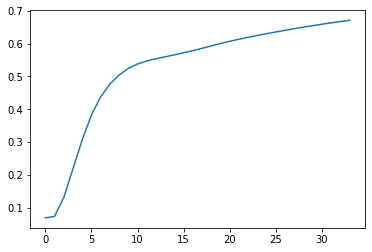

In [ ]:
plt.plot(errors[:, T_warmup:].mean(dim=0))